<a href="https://colab.research.google.com/github/electrojam/Data-Analysis-and-Prediction-Obesity/blob/main/prediccion_de_obesidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# análisis de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# evaluación y preprocesamiento
import sklearn.compose
#import janitor
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    LabelEncoder, OrdinalEncoder, StandardScaler, RobustScaler)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

# 1 Obtención, Resumen de datos y problemas

In [2]:
# Descargamos el dataset
df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


#### Descripcion de las columnas del dataset

Gender – Male or Female.  
Age – The person’s age in years.  
Height – Height in meters.  
Weight – Weight in kilograms.    
family_history_with_overweight – Whether the person
  has a family history of being overweight (yes/no).  
FAVC – If the person frequently consumes high-calorie foods (yes/no).  
FCVC – Frequency of vegetable consumption (scale from 1 to 3).  
NCP – Number of main meals per day.  
CAEC – Frequency of consuming food between meals (Never, Sometimes, Frequently, Always).  
SMOKE – Whether the person smokes (yes/no).  
CH2O – Daily water intake (scale from 1 to 3).  
SCC – If the person monitors their calorie intake (yes/no).  
FAF – Physical activity frequency (scale from 0 to 3).  
TUE – Time spent using technology (scale from 0 to 3).  
CALC – Frequency of alcohol consumption (Never, Sometimes, Frequently, Always).  
MTRANS – Main mode of transportation (Automobile, Bike, Motorbike, Public Transportation, Walking).  
NObeyesdad – Obesity level (Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II, Obesity Type III).  

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   int64  
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

# 2 EDA y Análisis estadístico

### Estadística descriptiva EDA
Generamos la estasdística descriptiva solo para los datos numéricos.
- count nos dice el número de filas no vacías en una característica.
- La media nos dice el valor medio de esa característica.
- std nos dice el valor de desviación estándar de esa característica.
- min nos dice el valor mínimo de esa característica.
- 25%, 50% y 75% son el percentil/cuartil de cada característica. Esta información del cuartil nos ayuda a detectar valores atípicos.
- max nos dice el valor máximo de esa característica.

In [4]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.315964,1.701620,86.586035,2.418986,2.685651,2.008053,1.010313,0.657861
std,6.357078,0.093368,26.191163,0.533996,0.778079,0.612950,0.850613,0.608926
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.630000,65.470000,2.000000,2.660000,1.585000,0.125000,0.000000
50%,23.000000,1.700000,83.000000,2.390000,3.000000,2.000000,1.000000,0.625000
75%,26.000000,1.770000,107.430000,3.000000,3.000000,2.480000,1.670000,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


### 2.1 Análisis de ditribución

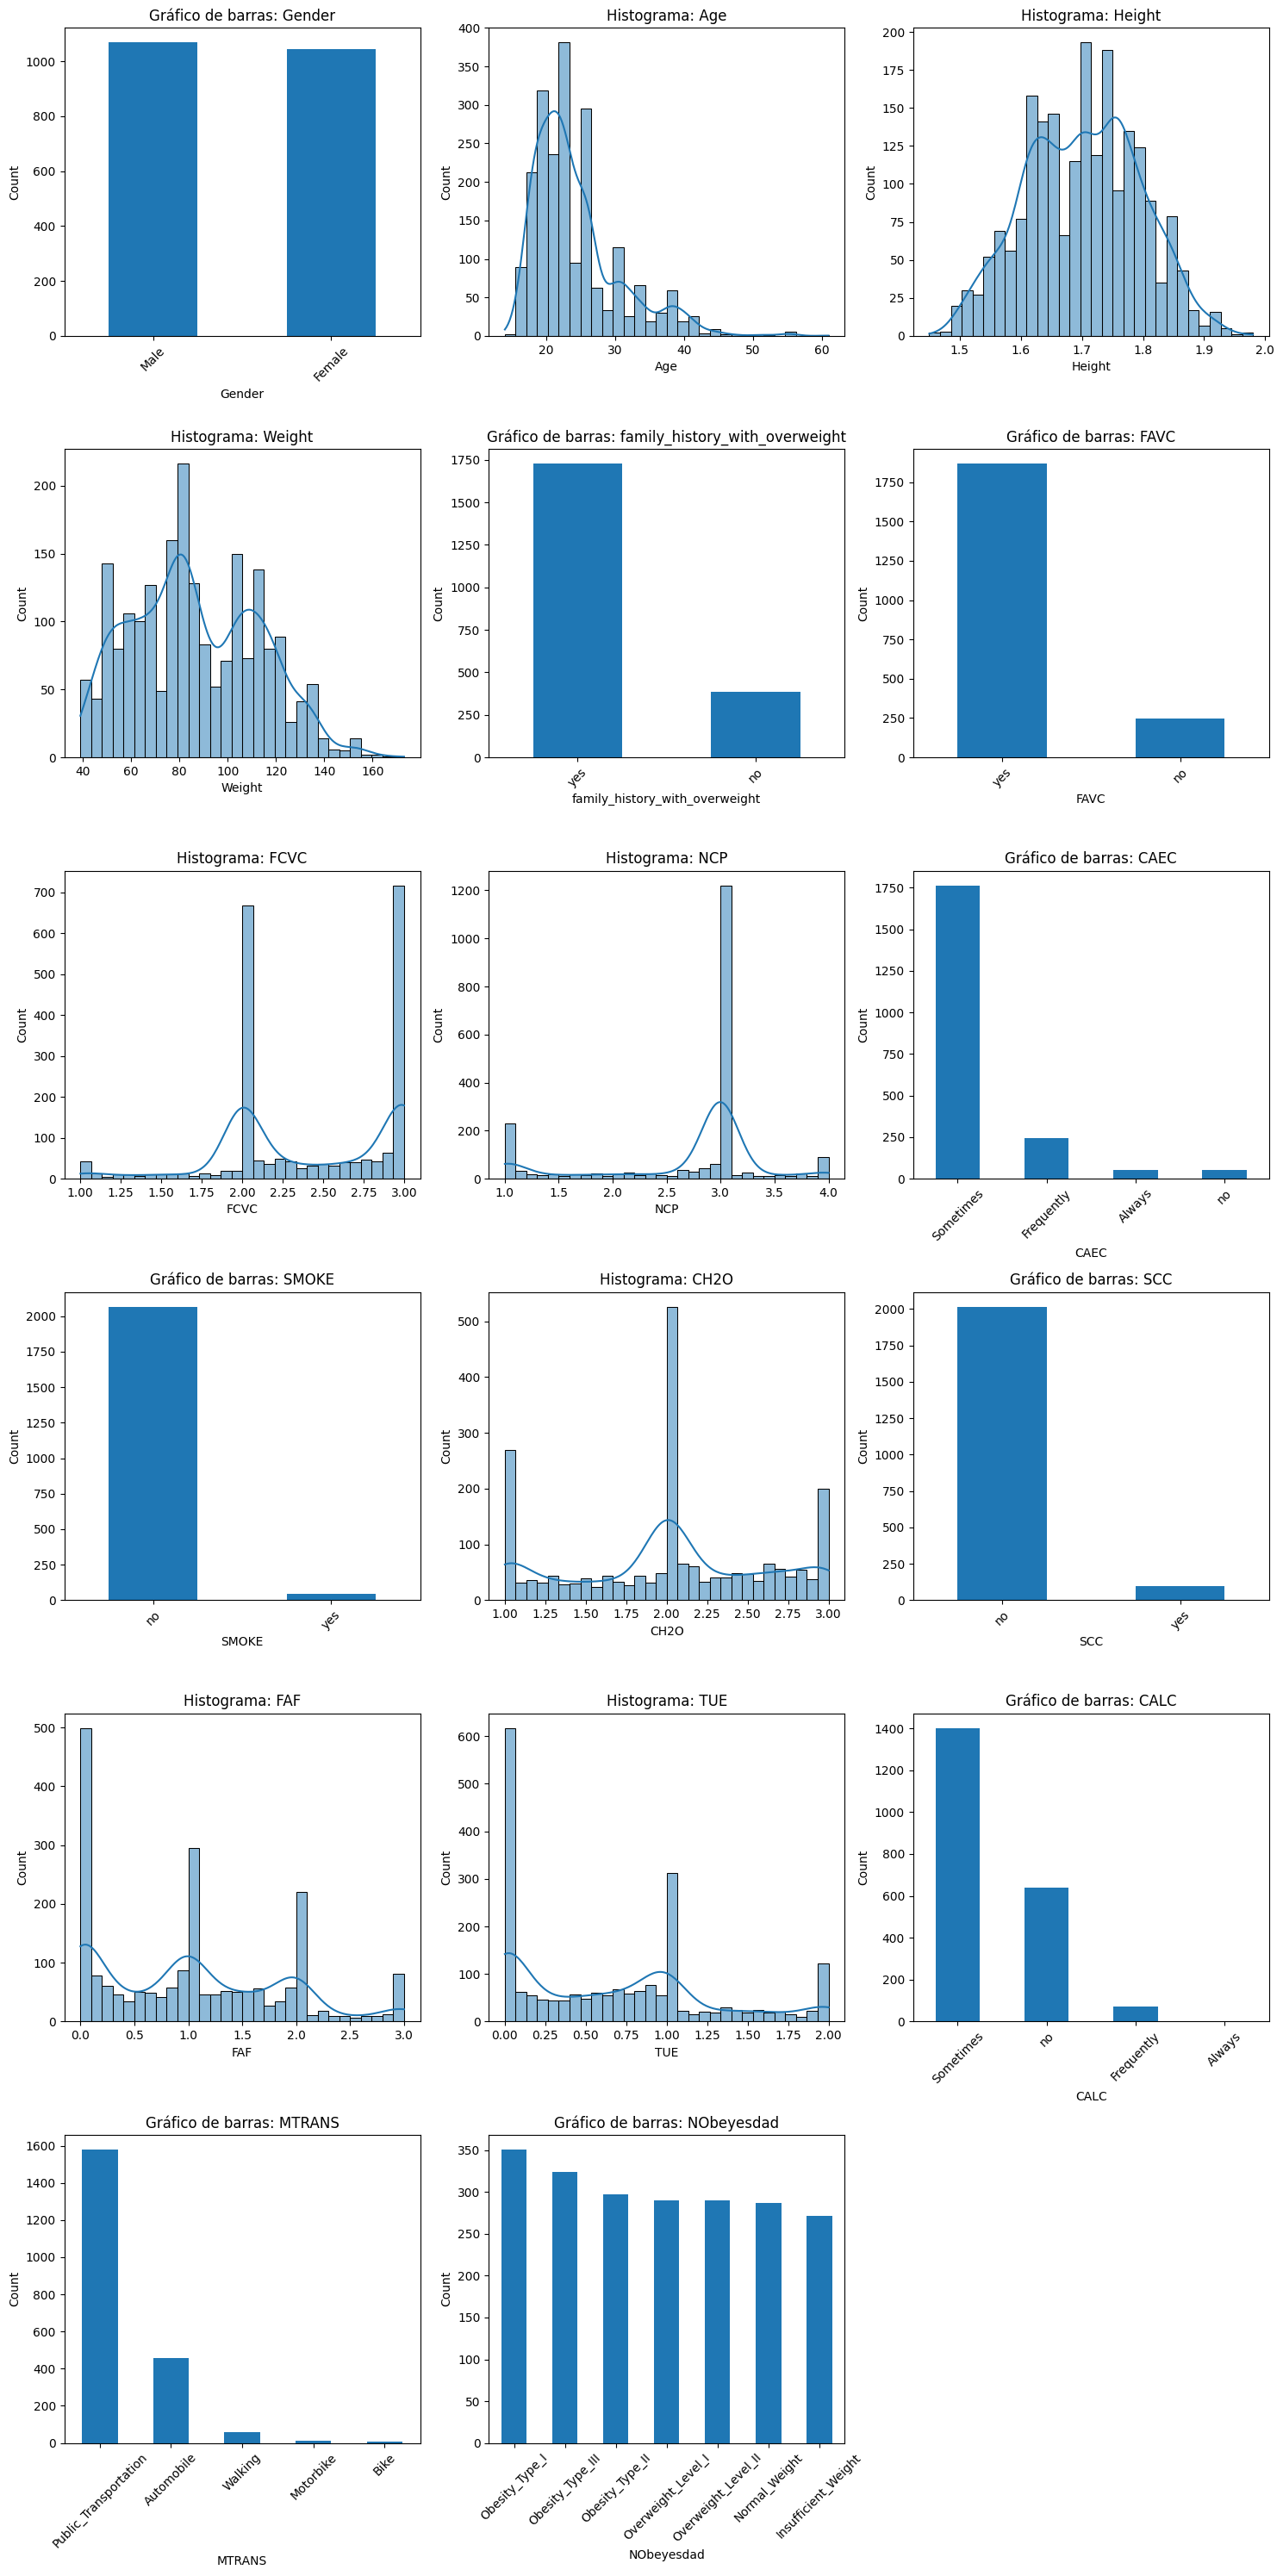

In [5]:
# Análisis de distribución
#Graficamos la ditribución de los datos de todas las variables

# definos tamaño de la grilla
n_cols = 3
n_rows = (len(df.columns) + n_cols - 1) // n_cols

# creamos figura y axes
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Iteramos a través de las columnas del df
for i, column in enumerate(df.columns):
  ax = axes[i]
  if df[column].dtype in ["float64", "int64"]:
    # Histograma de columnas numéricas
    sns.histplot(df[column], kde=True, ax=ax, bins=30)
    ax.set_title(f"Histograma: {column}")
  else:
    # Gráfico de barras columnas categóricas
    df[column].value_counts().plot(kind="bar", ax=ax)
    ax.set_title(f"Gráfico de barras: {column}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_ylabel("Count")

# Removemos subplots vacíios si hay
for j in range(len(df.columns), len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


##### **Actividad y Estilo de Vida**



*   FAF La mayoría de las personas no realizan actividad física.
* smoke También la gran mayoría de las personas no son fumadores.
*   SCC La mayor parte no tiene de hábito medir la cantdad de ingestas de calorías.
*   TUE Una parte importante de personas utiliza la tecnología de manera moderada.
*   CALC También la mayoría ha consumido alcohol.

##### **Hábitos alimenticios**

*  FAVC La gran mayoría consume alimentos altos en calorías.
* FCVC en el consumo de vegetales se oserva que los valores se agrupan hacia la escala media alta de la gráfica.
* NCP el conume de tres comidas principales diarias es lo regular en las personas.
* CAEC es muy frecuente el consumo de alimentos entre comidas.
*  SCC El monitoreo del consumo de calorías no es habitual.

#####  **Factores genéricos**

* Family_history_overweight la mayor parte de las personas tienen familiares con sobre peso.

##### **Obesidad**
* La columnas de nivel de obesidad muestra una distribución balanceada.

##### **Observaciones claves**

1. Actividad Física: Las personas tienden a moivilizarse en transporte pública y dejan a un lado la práctica de ejercicio.

2. Dietas no balanceadas: El riesgo de contraer obesidad está muy ligado a la ingesta de alimentos entre comidas y el no monitoreo de calorías.

3. Factor Genético: Los antecedentes familiares con obesidad juega un papel importante en la adquisición de obesidad.

4. Tendencias en obesidad: La obesidad tipo I es el nivel predominante de obesidad.


#### **Conclusiones de las distribuciones**

La visualización de la distribución de los datos revela una relación entre el estilo de vida, hábitos alimenticios, factor genético con el indicador de obesidad, siendo los más notables, el consumo entre comidas, ausencia de ejercicios y no monitoreo de calorías.

### 2.2 Análisis de valores atípicos

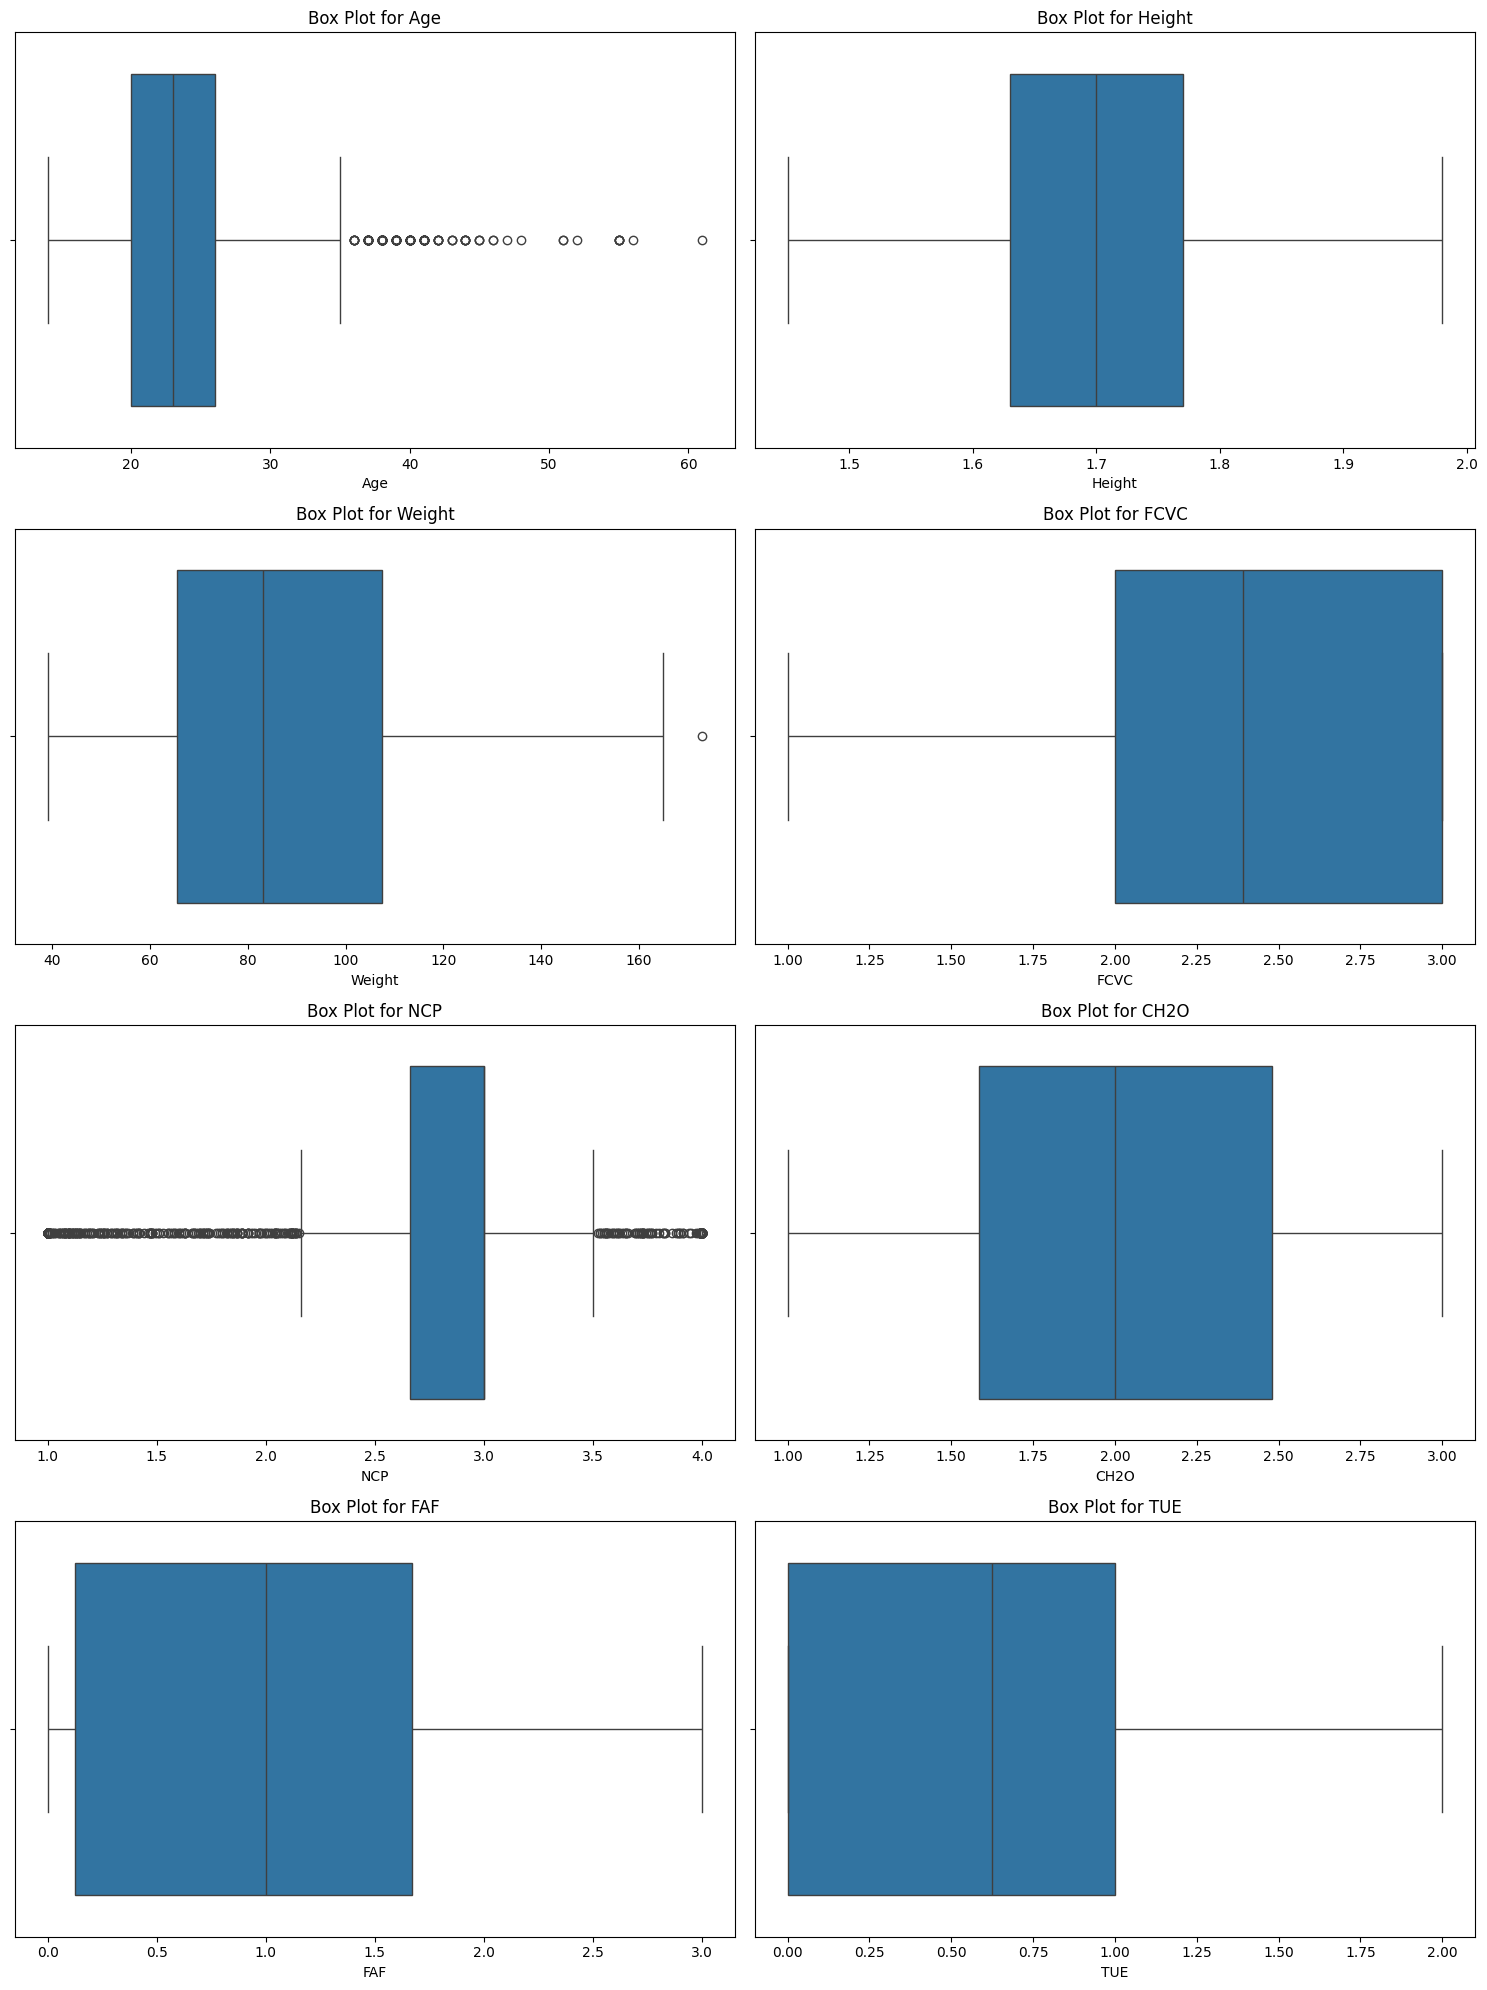

In [6]:
# Graficamos mediante boxplot para analizar percentiles y valores atípicos

numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

n_cols = 2
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols

plt.figure(figsize=(15, 5 * n_rows))
for i, column in enumerate(numerical_columns, start=1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=df, x=column)
    plt.title(f'Box Plot for {column}')

plt.tight_layout()
plt.show()

### 2.3 Análisis de duplicados

In [7]:
num_duplicates = df.duplicated().sum()
print(f"Número de filas duplicados: {num_duplicates}")

Número de filas duplicados: 24


# 3 Ingeniería de Características

Hallaremos nuevas columnas (features) a partir de las existentes.

In [8]:
# Calculamos BMI índice de masa corporal con features weight y height
df = df.copy()
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

# Categorizamos en Joven, Adulto, Elderly por rangos de edad (age).
df['Age_Category'] = pd.cut(df['Age'], bins=[0, 18, 60, float('inf')], labels=['Joven', 'Adulto', 'Anciano'])


In [9]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI,Age_Category
0,Female,21,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight,24.386526,Adulto
1,Female,21,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,24.238227,Adulto
2,Male,23,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,23.765432,Adulto
3,Male,27,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,26.851852,Adulto
4,Male,22,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,28.342381,Adulto


# 4 Procesamiento de Datos

### 4.1 Eliminar duplicados

In [10]:
df_proc = df.copy()

In [11]:
df_proc.drop_duplicates(inplace=True)

In [12]:
# Identificamos y guardamos los nombres de las columnas numéricas
numerical_columns = df_proc.select_dtypes(include=['float64', 'int64']).columns
numerical_columns

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI'], dtype='object')

### 4.2 Codificación de variables categóricas

In [13]:
# Identificamos y guardamos nombres de las columnas categóricas
cat_cols = df_proc.select_dtypes(include=['object', 'category']).columns
cat_cols

Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS', 'NObeyesdad', 'Age_Category'],
      dtype='object')

In [14]:
# Label Encoding
for col in cat_cols:
  cat_encoder = LabelEncoder()
  df_proc[col] = cat_encoder.fit_transform(df_proc[col])

df_proc.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI,Age_Category
0,0,21,1.62,64.0,1,0,2.0,3.0,2,0,2.0,0,0.0,1.0,3,3,1,24.386526,0
1,0,21,1.52,56.0,1,0,3.0,3.0,2,1,3.0,1,3.0,0.0,2,3,1,24.238227,0
2,1,23,1.80,77.0,1,0,2.0,3.0,2,0,2.0,0,2.0,1.0,1,3,1,23.765432,0
3,1,27,1.80,87.0,0,0,3.0,3.0,2,0,2.0,0,2.0,0.0,1,4,5,26.851852,0
4,1,22,1.78,89.8,0,0,2.0,1.0,2,0,2.0,0,0.0,0.0,2,3,6,28.342381,0


### 4.3 Escalamiento

In [15]:
df_scaled = df_proc.copy()

# Inicializamos escalador
scaler = RobustScaler()

# Aplicams el escaler a columnas numéricas
df_scaled[numerical_columns] = scaler.fit_transform(df_scaled[numerical_columns])
df_scaled.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI,Age_Category
0,0,-0.333333,-0.571429,-0.454600,1,0,-0.4,0.000000,2,0,0.000000,0,-0.643087,0.369,3,3,1,-0.382456,0
1,0,-0.333333,-1.285714,-0.645008,1,0,0.6,0.000000,2,1,1.142857,1,1.286174,-0.631,2,3,1,-0.395130,0
2,1,0.000000,0.714286,-0.145186,1,0,-0.4,0.000000,2,0,0.000000,0,0.643087,0.369,1,3,1,-0.435537,0
3,1,0.666667,0.714286,0.092824,0,0,0.6,0.000000,2,0,0.000000,0,0.643087,-0.631,1,4,5,-0.171760,0
4,1,-0.166667,0.571429,0.159467,0,0,-0.4,-6.666667,2,0,0.000000,0,-0.643087,-0.631,2,3,6,-0.044374,0


### 4.4 Correlacion

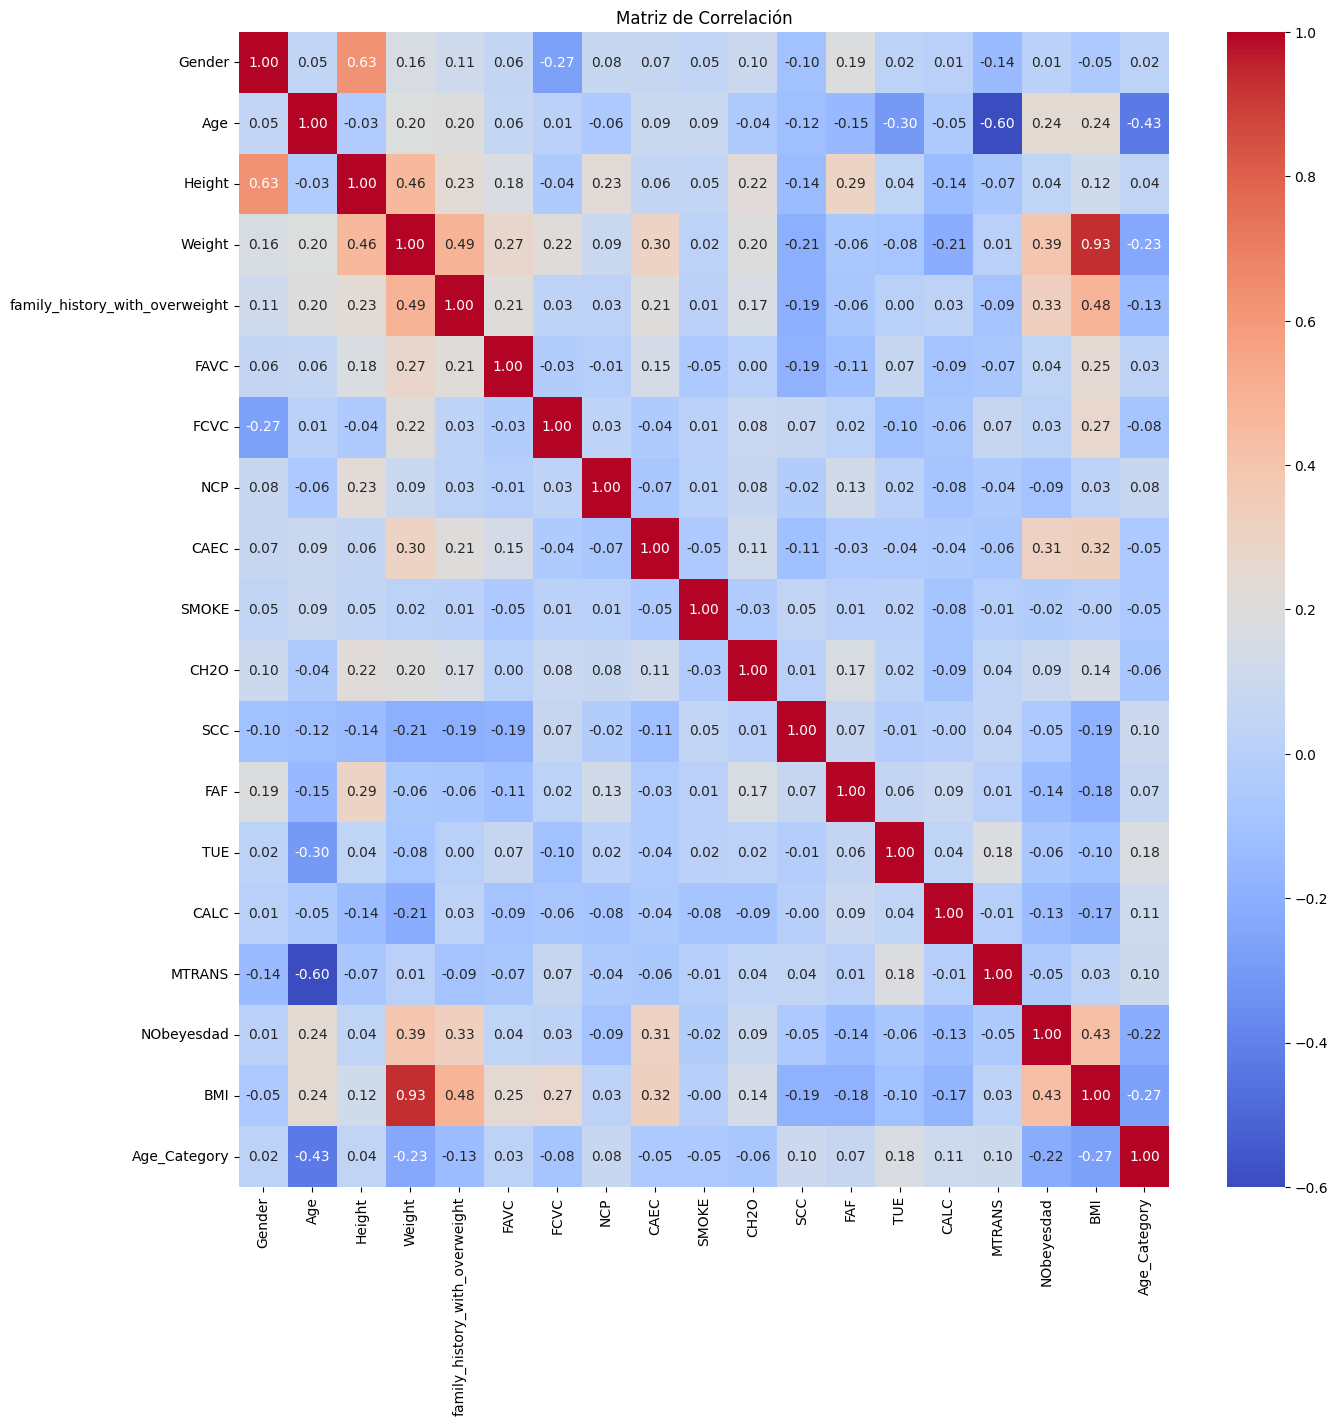

In [16]:
# Graficamos mapade calor de correlación
matrix_corr = df_scaled.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(matrix_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

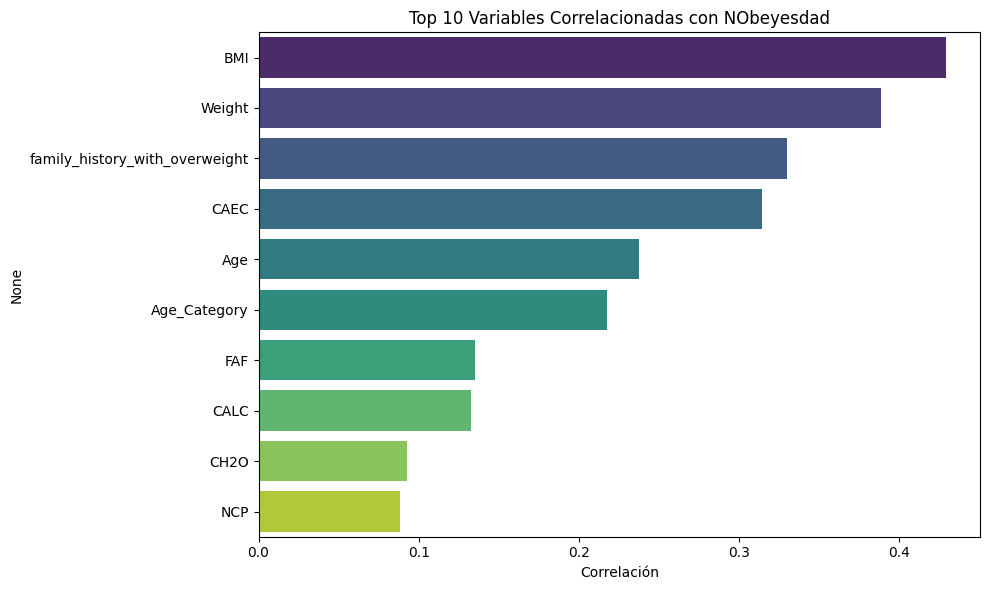

In [17]:
# Barplot de top10 de correlación con NObeyesad

# Removemos autocorrelación NObeyesdad
nobeyesdad_corr = matrix_corr["NObeyesdad"].drop("NObeyesdad")

# Ordenamos variables por el valor absoluto de sus correlaciones...
# ...solo escogemos las 10 mayores correlaciones
top_10_corr = nobeyesdad_corr.abs().sort_values(ascending=False).head(10)

# Barplot de top 10 correlaciones
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_corr.values, y=top_10_corr.index, palette='viridis')
plt.xlabel('Correlación')
plt.title('Top 10 Variables Correlacionadas con NObeyesdad')
plt.tight_layout()
plt.show()


# 5 Modelando

### 5.1 Dividir datos

In [18]:
X = df_scaled.drop(columns=['NObeyesdad'], axis=1)
y = df_scaled['NObeyesdad']

In [19]:
# datos entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 5.2 Creación de modelos

In [20]:
# Creamos dict cvo modelos de machine learning escogidos
models = {
    "KNN":KNeighborsClassifier(),
    "Decision Tree Classifier":DecisionTreeClassifier(),
    "Random Forest Classifier":RandomForestClassifier(),
    "Gradient Boosting Classfifier":GradientBoostingClassifier(),
    "Ada Boost Classifier":AdaBoostClassifier(),
    "Logistic Regresion":LogisticRegression()
}

In [21]:
# Creamos dict vacío con llave valor de métricas
metrics = {
    "Model":[],
    "Accuracy":[],
    "Precission":[],
    "Recall":[]
}

# En un bucle entrenamos cada modelo ML y hacemos pruebas,
# también calculamos métricas accuracy, precission, recall
# y guardamos en dict metrics

for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accu = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  metrics["Model"].append(name)
  metrics["Accuracy"].append(accu * 100)
  metrics["Precission"].append(prec * 100)
  metrics["Recall"].append(recall * 100)
  print("=" * 30)
  print(f"Modelo: {name}")
  print(f"Accuracy: {accu * 100}")
  print(f"Precision: {prec * 100}")
  print(f"Recall: {recall * 100}")

Modelo: KNN
Accuracy: 81.65869218500798
Precision: 81.67993645818241
Recall: 81.65869218500798
Modelo: Decision Tree Classifier
Accuracy: 96.96969696969697
Precision: 97.14454752360135
Recall: 96.96969696969697
Modelo: Random Forest Classifier
Accuracy: 99.20255183413079
Precision: 99.22777037165635
Recall: 99.20255183413079
Modelo: Gradient Boosting Classfifier
Accuracy: 97.4481658692185
Precision: 97.60283747119537
Recall: 97.4481658692185
Modelo: Ada Boost Classifier
Accuracy: 77.35247208931419
Precision: 74.43367771542005
Recall: 77.35247208931419
Modelo: Logistic Regresion
Accuracy: 86.60287081339713
Precision: 86.97306961104438
Recall: 86.60287081339713


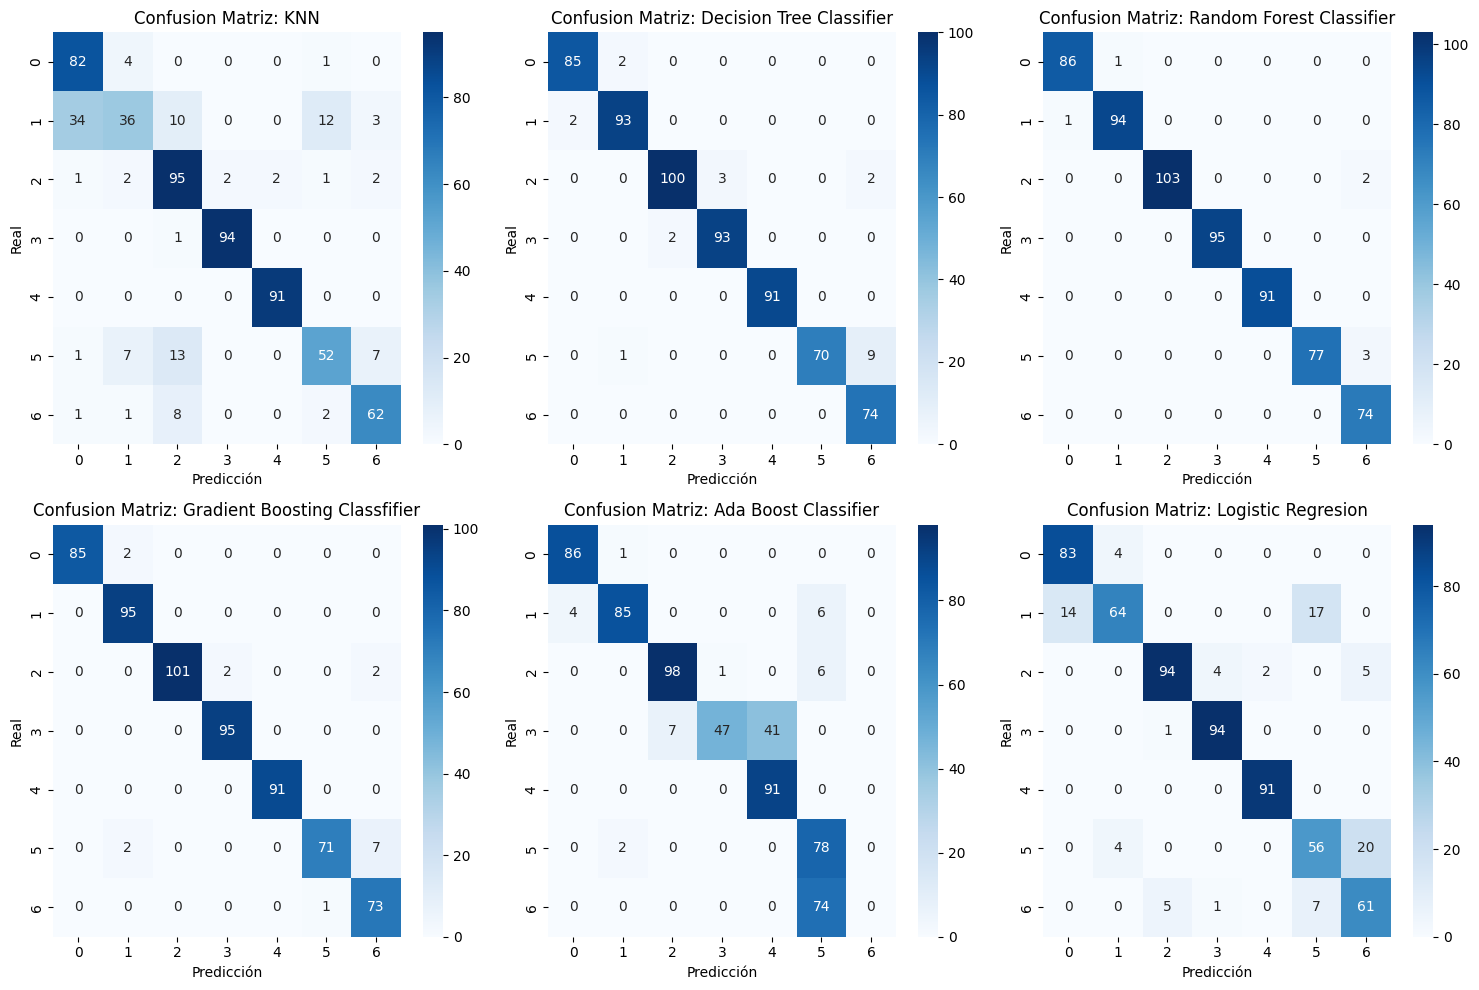

In [27]:
# Heatmap de matriz de confusión de los modelos de ML creados

# Análisis de distribución
#Graficamos la ditribución de los datos de todas las variables

# definos tamaño de la grilla
n_cols = 3
n_rows = (len(models) + n_cols - 1) // n_cols

# creamos figura y axes
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Graficamos una grilla de Heatmap de matriz de confusión de los modelos de ML
for i, (name, model) in enumerate(models.items()):
  ax = axes[i]
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
  ax.set_title(f"Confusion Matriz: {name}")
  ax.set_xlabel("Predicción")
  ax.set_ylabel("Real")

# Removemos subplots vacíios si hay
for j in range(len(models), len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()